# Optimisation non linéaire de type Mix de Produits.

## Introduction

Dans ce notebook, je vais faire une optimisation non linéaire de type mixe de produits.
C'est non linéaire, parce que , plus l'usine réalise de produits, moins le prix de vente est cher
 ce qui provoque une élevation au carré dans la fonction objectif.
J'ajoute des contraintes de stocks et de temps de travail Maximum.
Et si la somme du nombre d'objets produits A, B et C dépasse un certain nombre, alors un coût de maintenance k s'applique ( Coûts discontinus).
De plus on va modéliser le problème mathématique à l'aide de Latex avant tout.

** CREATION EN COURS - SUJET A IMPORTANTES MODIFICATIONS ET CONTROLES !**

Etude fournie par estelle derrien - Github : estellederrien

* Lien d'origine du problème ( Réduit à une machine): 
https://www.emse.fr/~beaune/solveur/expnl.html

(Note : Les fonctions de décroissance du prix ne sont pas logiques en vie réelle, dans son exemple)

# Sommaire :

- Description du problème
- Graphique du prix de vente en fonction de la quantité d'objets produits
- Modélisation mathématique avec Latex.
- Création du problème avec Gekko.
- Création du problème avec Cplex et vérification si le résultat est le même qu'avec Gekko.
- Itérations dans la fonction objectif et les contraintes de Gekko, pour écrire plus vite l'optimisation.
- Graphique des coûts variables.
- Modélisation mathématique des variables binaires conditionnelles discontinues.
- On code avec CPLEX les variables binaires conditionnelles discontinues
- On code avec Gekko les variables binaires conditionnelles discontinues
- Liens Internet nécessaires pour comprendre.


# Description du problème

J'ai une machine qui produit 3 pièces. La machine peut travailler 1000 heures au maximum. 

Le prix de vente des pièces A,B et C diminue avec la quantité produite.
Je dois au minimum fabriquer 200 pièces A, 200 pièces B , et 100 pièces C.

Le prix de vente de la pièce A est 81-quantité de A/200 ( Le prix décroit si on produit beaucoup)

Le prix de vente de la pièce B est 90-quantité de B/100 

Le prix de vente de la pièce C est 85-quantité de C/100 

On a pour contrainte de stocks 3000 kgs de métal,
2000 heures de temps de travail et 2500 kgs de plastique.

si Somme de A, B ou C sont  < 500, alors on soustrait 10 euros de coût de maintenance dans la fonction objectif.

si Somme de A, B ou C sont > 500 alors on soustrait 20 euros de côut de maintenance dans la fonction objectif.

Quel type et Combien de pièces produire afin de maximiser mon profit ?

# Graphique du prix de vente en fonction de la quantité d'objets produits

Le prix unitaire décroit quand la production est plus importante, différemment pour chaque objet A, B et C.
Normalement, ces fonctions sont fournies par le service commercial de l'usine.

Text(0, 0.5, 'Prix unitaire')

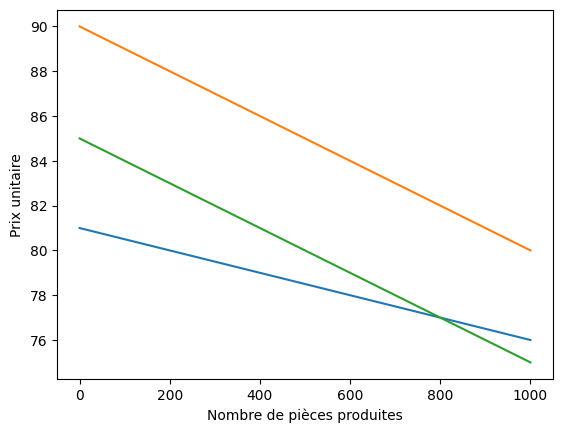

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Prix unitaire de l'objet A
def f(A):
    return 81 - ( A / 200  ) 
# Prix unitaire de l'objet B
def fb(B):
    return 90 - (B / 100)
# Prix unitaire de l'objet C
def fc(C):
    return 85 - (C / 100)

x = np.linspace(0, 1000, 1000)
plt.plot(x, f(x))
plt.plot(x, fb(x))
plt.plot(x, fc(x))
plt.xlabel('Nombre de pièces produites')
plt.ylabel('Prix unitaire')


# Modélisation mathématique
(Il y a un Bug de passage de lignes dans Github)

$$
max \sum_{1}^{i}  xi * (PrixVente(i) - \frac{xi}{Reduction}) \newline
\textit{Sous les contraintes} \newline
\sum_{1}^{i} xi * Metal(i) \leq 3000 \newline
\sum_{1}^{i} xi * Htravail(i) \leq 2000 \newline
\sum_{1}^{i} xi * Plastique(i) \leq 2500 \newline
$$


On réécrit la modélisation comme ça, à cause du bug de passage des lignes dans github.

In [7]:
from IPython.display import display, Math, Latex
display(Math(r'max \sum_{1}^{i}  xi * (prixVente(i) - \frac{xi}{reduction}) '))
display(Math(r'Sous.les.contraintes'))
display(Math(r'\sum_{1}^{i} xi * metal(i) \leq 3000 '))
display(Math(r'\sum_{1}^{i} xi * h_travail(i) \leq 2000 '))
display(Math(r'\sum_{1}^{i} xi * plastique(i) \leq 2500 '))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

# Création du problème avec Gekko.

Dans un premier temps, on va déjà faire tourner le programme sans les variables binaires, mais avec seulements les contraintes de type stock et temps machine .

In [8]:
# On importe Gekko
from gekko import GEKKO

m = GEKKO(remote=False) # Initialize gekko

#The example problem that you referenced uses the default IPOPT solver. 
# To get a binary or integer solution, switch to the APOPT solver.
# The default solver is IPOPT and it doesn't give an integer solution. Try the APOPT solver instead.
# https://apmonitor.com/wiki/index.php/Main/OptionApmSolver
m.options.SOLVER = 1

# Variables générales
pieces = ['A','B','C']
disponibilite_machine = 1000
stock_metal = 3000
stock_heures_travail = 2000
stock_plastique = 2500

# Les caractéristiques de nos produits A, B et C au format dictionnaire, 
# pour pouvoir itérer dessus ensuite dans les contraintes.
prix_vente = {'A':81,'B':90,'C':85}
metal = {'A':3,'B':4,'C':5}
travail = {'A':1,'B':2,'C':2}
plastique = {'A':3,'B':5,'C':4}

# On crée les variables de décision , ce sera notre nombre de pièces à réaliser, vu qu'on ne 
# peut pas avoir 1/2 objet, on dit que ce sont des variables entières.

A = m.Var(value=1,lb=0,ub=10000,integer=True)
B = m.Var(value=1,lb=0,ub=10000,integer=True)
C = m.Var(value=1,lb=0,ub=10000,integer=True)

# Voici notre fonction objectif , qui tient compte du fait que plus on produits de pièces, Moins ça coute cher !!
# On voit qu'elle est non linéaire parce que A , B et C sont élevés au carré !!
m.Maximize( A * (81 - ( A / 200  )) + B * (90 - (B / 100)) + C * (85 - (C / 100)))

# contraintes
m.Equation( A + B + C <= disponibilite_machine) # La machine un peut travailler 1000 heures maximum
m.Equation(3 * A + 4 * B + 5 * C <= stock_metal)
m.Equation(1 * A + 2 * B + 2 * C <= stock_heures_travail)
m.Equation(3 * A + 5 * B + 4 * C <= stock_plastique)
m.Equation(A >= 200)
m.Equation(B >= 200)
m.Equation(C >= 100)



# On imprime le résultat 
m.options.IMODE = 3 # Steady state optimization

m.solve(disp=False) # Solve

print('Solution')

print('A: ' + str(A.value))
print('B: ' + str(B.value))
print('C: ' + str(C.value))

print('Objectif: ' + str(-m.options.objfcnval))

Solution
A: [365.0]
B: [201.0]
C: [100.0]
Objectif: 54984.865


# Création du problème avec Cplex et vérification si le résultat est le même qu'avec Gekko.

On voit que CPLEX trouve exactement la même solution.

In [9]:
import cplex
import docplex.mp
from docplex.mp.model import Model

# Variables générales
pieces = ['A','B','C']
disponibilite_machine = 1000
stock_metal = 3000
stock_heures_travail = 2000
stock_plastique = 2500

# On crée notre modèle
model = Model(name='LP_example', log_output=True)

# On crée nos variables de décision
A = model.integer_var(name='A')
B = model.integer_var(name='B')
C = model.integer_var(name='C')

# On crée la fonction objectif
model.maximize(A * (81 - ( A / 200  )) + B * (90 - (B / 100)) + C * (85 - (C / 100)))

# On crée les contraintes
model.add_constraint( A + B + C <= disponibilite_machine) # La machine un peut travailler 1000 heures maximum
model.add_constraint(3 * A + 4 * B + 5 * C <= stock_metal)
model.add_constraint(1 * A + 2 * B + 2 * C <= stock_heures_travail)
model.add_constraint(3 * A + 5 * B + 4 * C <= stock_plastique)
model.add_constraint(A >= 200)
model.add_constraint(B >= 200)
model.add_constraint(C >= 100)

model.print_information() 
sol_model = model.solve()
model.print_solution()

Model: LP_example
 - number of variables: 3
   - binary=0, integer=3, continuous=0
 - number of constraints: 7
   - linear=7
 - parameters: defaults
 - objective: maximize quadratic
 - problem type is: MIQP
Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Found incumbent of value 42000.000000 after 0.00 sec. (0.00 ticks)
Tried aggregator 1 time.
MIQP Presolve eliminated 5 rows and 0 columns.
Reduced MIQP has 2 rows, 3 columns, and 6 nonzeros.
Reduced MIQP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 3 nonzeros.
Presolve time = 0.02 sec. (0.00 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 3 columns, and 6 nonzeros.
Reduced MIQP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 3 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP

objective: 54987.480
status: OPTIMAL_SOLUTION(2)
  A=364
  B=200
  C=102


# Itérations pour aller plus vite dans l'optimisation avec Gekko.

Pour itérer avec Gekko, c'est malheureusement différent du solveur Python Pulp : 

https://stackoverflow.com/questions/64542594/how-could-constraints-be-dynamically-constructed-in-gekko

https://www.solvermax.com/blog/production-mix-model-9-gekko

On essaye donc d'itérer dans la fonction objectif et les contraintes, avec la méthode de John Hedengren :

Edit : On voit qu'on ne peut pas paramètrer les (value=1,lb=0,ub=10000,integer=True) dans le tableau Array, on ne peut donc pas spécifier que ce sont des variables entières. ( résolution en cours... )


In [10]:
# On importe Gekko
from gekko import GEKKO

m = GEKKO(remote=False) # Initialize gekko

m.options.SOLVER = 1

# Variables générales
pieces = ['A','B','C']
disponibilite_machine = 500
stock_metal = 3000
stock_heures_travail = 2000
stock_plastique = 2500

# Les caractéristiques de nos produits A, B et C au format dictionnaire, 
# pour pouvoir itérer dessus ensuite dans les contraintes.
prix_vente = {'A':81,'B':90,'C':85}
metal = {'A':3,'B':4,'C':5}
travail = {'A':1,'B':2,'C':2}
plastique = {'A':3,'B':5,'C':4}


# Cette contrainte itérante écrite à la manière de Python Pulp ne fonctionne pas.
# m.Equation(sum(metal[i] * pieces[i] for i in pieces) <= stock_metal)

# Autre tentative d'itération :

# On crée les variables de décision avec la méthode de John Hedengren
va = m.Array(m.Var(value=1,lb=0,ub=10000,integer=True),(len(pieces)))  # array

# on crée un dictionnaire, astuce donnée par John Hedengren, pour pouvoir itérer après dans les contraintes
vd = {}                             # dictionary
for i,xi in enumerate(pieces):
    vd[xi] = va[i]

# Voici notre fonction objectif , qui tient compte du fait que plus on produits de pièces, Moins ça coute cher !!
# On voit qu'elle est non linéaire parce que A , B et C sont élevés au carré !!
# m.Maximize( A * (81 - ( A / 200 )) + B * (90 - (B / 100)) + C * (85 - (C / 100)))

# On se sert du tableau pour écrire la fonction objectif
m.Maximize( va[0] * (81 - ( va[0] / 200 )) + va[1] * (90 - ( va[1] / 100)) +  va[2]  * (85 - (va[2]  / 100) ))


# Contraintes, On les écrit désormais en itérant

# model.add_constraint(3 * A + 4 * B + 5 * C <= stock_metal) ( Ancienne équation ) = 
model.add_constraint(m.sum([metal[xi]*vd[xi] for xi in pieces])<=stock_metal)

# model.add_constraint(1 * A + 2 * B + 2 * C <= stock_heures_travail) ( Ancienne équation ) = 
model.add_constraint(m.sum([travail[xi]*vd[xi] for xi in pieces])<=stock_heures_travail)

# model.add_constraint(3 * A + 5 * B + 4 * C <= stock_plastique) ( Ancienne équation ) = 
model.add_constraint(m.sum([plastique[xi]*vd[xi] for xi in pieces])<=stock_plastique)

# On imprime le résultat 
m.options.IMODE = 3 # Steady state optimization

m.solve(disp=False) # Solve

print('Solution')

# On affiche le résultat
for xi in pieces:
    print(xi,vd[xi].value[0])


print('Objectif: ' + str(-m.options.objfcnval))




TypeError: 'GKVariable' object is not callable

# Ajout des variables binaires conditionnelles.

Tout d'abord, on visualise nos contraintes de type <b>discontinues</b> avec Matplot lib :

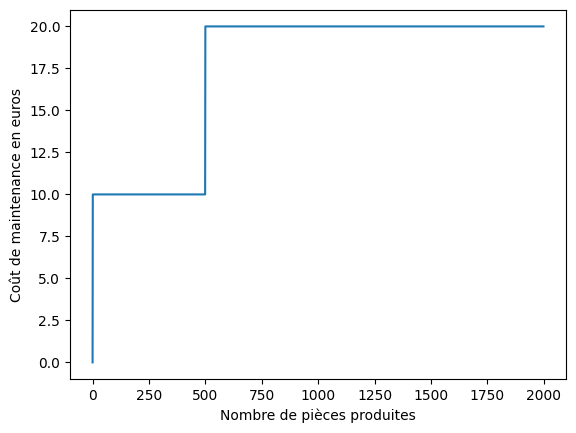

In [ ]:
# On visualise nos contraintes de type discontinues avec les valeurs réelles de notre problème
import matplotlib.pyplot as plt
plt.plot([0,0,1,499,500,1999], [0,0,10, 10, 20,20,])
plt.xlabel('Nombre de pièces produites')
plt.ylabel('Coût de maintenance en euros')
plt.show()

# Modélisation mathématique des variables binaires conditionnelles discontinues.




Donc voici nos 2 variables binaires:

z = { 1 si la production de A + B + C < 500

      0 si la production de A + B + C > 500

k = { 1 si la production de A + B + C >= 500

      0 si la production de A + B + C < 500


      



# On code avec CPLEX les variables binaires conditionnelles discontinues

Gérer les variables binaires conditionnelles est beaucoup plus facile avec Python CPLEX.

In [ ]:
import cplex
import docplex.mp
from docplex.mp.model import Model

# Variables générales
pieces = ['A','B','C']
disponibilite_machine = 1000
stock_metal = 3000
stock_heures_travail = 2000
stock_plastique = 2500

# On crée notre modèle
model = Model(name='LP_example', log_output=True)

# On crée nos variables de décision
A = model.integer_var(name='A')
B = model.integer_var(name='B')
C = model.integer_var(name='C')

# On crée nos variables binaires
z = model.binary_var(name='z') # Cette variable va servir à déterminer si on affecte ou pas les coûts si la somme des objets < 500
k = model.binary_var(name='k') # Cette variable va servir à déterminer si on affecte ou pas les coûts si la somme des objets > 500



# On crée la fonction objectif et on y inclut les coûts à soustraire
model.maximize(A * (81 - ( A / 200  )) + B * (90 - (B / 100)) + C * (85 - (C / 100)) - z * 10 - k * 20 )

# On crée les contraintes
model.add_constraint( A + B + C <= disponibilite_machine) # La machine un peut travailler 1000 heures maximum
model.add_constraint(3 * A + 4 * B + 5 * C <= stock_metal)
model.add_constraint(1 * A + 2 * B + 2 * C <= stock_heures_travail)
model.add_constraint(3 * A + 5 * B + 4 * C <= stock_plastique)
model.add_constraint(A >= 200)
model.add_constraint(B >= 200)
model.add_constraint(C >= 100)

#if then constraint
model.add_constraint(model.if_then( A + B + C <= 499, z == 1))
model.add_constraint(model.if_then( A + B + C >= 499, k == 1))

model.print_information() 
sol_model = model.solve()
model.print_solution()

Model: LP_example
 - number of variables: 7
   - binary=4, integer=3, continuous=0
 - number of constraints: 11
   - linear=7, indicator=2, equiv=2
 - parameters: defaults
 - objective: maximize quadratic
 - problem type is: MIQP
Version identifier: 22.1.0.0 | 2022-03-25 | 54982fbec
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
MIQP Presolve eliminated 6 rows and 4 columns.
Reduced MIQP has 2 rows, 3 columns, and 6 nonzeros.
Reduced MIQP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 3 nonzeros.
Presolve time = 0.00 sec. (0.01 ticks)
Tried aggregator 1 time.
Reduced MIQP has 2 rows, 3 columns, and 6 nonzeros.
Reduced MIQP has 0 binaries, 3 generals, 0 SOSs, and 0 indicators.
Reduced MIQP objective Q matrix has 3 nonzeros.
Presolve time = 0.00 sec. (0.00 ticks)
Classifier predicts products in MIQP should be linearized.
MIP emphasis: balance optimality and feasibility.
MIP search method: dynamic search.
Parallel mod

# Liens : 
- https://stackoverflow.com/questions/74133047/binary-variable-in-gekko-optimization-problem

- https://math.stackexchange.com/questions/1851140/binary-integer-variables-in-linear-programming

- https://towardsdatascience.com/hands-on-integer-binary-linear-optimization-using-python-b6d8160cb1de

- https://stackoverflow.com/questions/56854536/from-pulp-to-gekko-syntax-mapping-for-constraints-objective-function

- https://stackoverflow.com/questions/64577733/how-to-make-constriants-in-gekko-by-for-loop

- https://stackoverflow.com/questions/64542594/how-could-constraints-be-dynamically-constructed-in-gekko